In [5]:
import os
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import imageio
import matplotlib.pyplot as plt

def load_file(datapath):
    with open(datapath, 'rb') as file:
        data = joblib.load(file)
        file.close()
    return data


def generate_images(inferencedata, imgpath, datetime):
    """
    Generates images for validation run evaluation. Note that the inference file loaded contains three prediction values:
    [CI lower bound, mean prediction, CI upper bound]. Currently only the mean prediction value is used to generate images.
    Image Normalisation: normalised using (nan)max/min temp values
    """
    vmin = np.nanmin(inferencedata)
    vmax = np.nanmax(inferencedata)
    figs = []

    for time in range(inferencedata.shape[0]):
        tempmap = sns.heatmap(inferencedata[time, :, :, 1], vmin=vmin, vmax=vmax, linewidth=0,
                                yticklabels=False, xticklabels=False)
        tempmap.set_title(f'Predicted Temperature {datetime[time]}')
        plt.close()
        fig = tempmap.get_figure()
        figname = f'tempmap_{time}.png'
        figs.append(figname)
        fig.savefig(os.path.join(imgpath, figname), bbox_inches='tight')
    return figs


def generate_GAN_images(inferencedata, imgpath):
    vmin = np.nanmin(inferencedata)
    vmax = np.nanmax(inferencedata)

    for time in range(inferencedata.shape[0]):
        fname = f'tempmap_{time}.png'
        if not os.path.isfile(os.path.join(imgpath, fname)):
            tempmap = sns.heatmap(inferencedata[time, :, :, 1], vmin=vmin, vmax=vmax, linewidth=0,
                                    yticklabels=False, xticklabels=False, cbar=False)
            plt.close()
            fig = tempmap.get_figure()
            fig.savefig(os.path.join(imgpath, fname), bbox_inches='tight', pad_inches=0)


def errorplots(errors, imgpath, datetime):
    lim = max(np.nanmax(errors), np.abs(np.nanmin(errors)))
    for time in range(errors.shape[0]):
        fname = f'error_{time}.png'
        if not os.path.isfile(os.path.join(imgpath, fname)):
            plt.imshow(errors[time, :, :], cmap='seismic', vmin=-lim, vmax=lim)
            plt.axis('off')
            plt.title(f'Error at time {datetime[time]}')
            plt.colorbar()
            plt.savefig(os.path.join(imgpath, fname), bbox_inches='tight')
            plt.close()


def animate_images(imgpath, gifpath, imgnames):
    if not os.path.isfile(gifpath):
        image_files = [os.path.join(imgpath, filename) for filename in imgnames]
        images = [imageio.imread(image_file) for image_file in image_files]
        imageio.mimsave(gifpath, images, duration=0.5, loop=0)
    

SETTINGS:

In [ ]:
palmref = 'mb5'

In [26]:
# PATHS AND FOLDERS
faulty_stations = ['C059A2225266', 'D63DFE9B164B', 'D07769DF208C', 'DF15D23E4B15', 'E2A0DF1A4941', 'E437CB2AF225', 'F5C16A4B6340',
                   'F033A8C6BB79', 'F4683D808CFB', 'D3FE8EEF188C', 'D883D89E6A24', 'EC032D8260EB', 'C3FD36A6C1BC', 'D083B9FD07FB', 
                   'EB90524D4F3E', 'FCBBD3B1DB2C']

palm_paths = {'mb4': 'mb_4_multi_stations_xy_N02.00m.nc',
              'mb5': 'mb_5_multi_stations_LCZ_xy_N02.00m.nc',
              'mb6': 'mb_6_multi_stations_LCZ_xy_N02.00m.nc',
              'mb7': 'mb_7_multi_stations_LCZ_xy_N02.00m.nc',
              'mb8': 'mb_8_multi_stations_LCZ_xy_N02.00m.nc'}



# predicted data
inferencedatapath = 'S:/pools/t/T-IDP-Projekte-u-Vorlesungen/Meteoblue/QRF/Data/QRF Inference/2024-3-5_15.12/2024-3-5_15.12.json'
measurementpath = 'S:/pools/t/T-IDP-Projekte-u-Vorlesungen/Meteoblue/Data/Messdaten/Daten_Meteoblue'

# image paths
imgpath = os.path.dirname(inferencedatapath) + '/TempMaps'
errorpath = os.path.dirname(inferencedatapath) + '/Errors'
if not os.path.isdir(imgpath):
    os.makedirs(imgpath)
if not os.path.isdir(errorpath):   
    os.makedirs(errorpath)
gifpath = os.path.dirname(imgpath) + '/tempmaps.gif'

# feature values
featuremappath = f'S:/pools/t/T-IDP-Projekte-u-Vorlesungen/Meteoblue/QRF/Data/QRF Feature Maps/'



In [7]:
# LOAD DATA
palmpath = f'S:/pools/t/T-IDP-Projekte-u-Vorlesungen/Meteoblue/Data/PALM Maps/{palm_paths[palmref]}'
filename = f'{palm_paths[palmref].split(".nc")[0]}_featuremaps.json'
inferencedata = load_file(inferencedatapath)
featuremaps = load_file(os.path.join(featuremappath, filename))
datetimes = list(featuremaps['datetime'][:, 0, 0])

# Temperature Map Generation

Temperature Map & GIF generation

In [8]:
fignames = generate_images(inferencedata, imgpath, datetimes)
animate_images(imgpath, gifpath, fignames)

GAN image (no title, cbar or axes) generation

In [9]:
imgpath = os.path.dirname(inferencedatapath) + '/GANMaps'
if not os.path.isdir(imgpath):
    os.makedirs(imgpath)
generate_GAN_images(inferencedata, imgpath)

# Evaluation of Errors
Two error estimations are done: first, the PALM temperature maps are compared to the temperature maps predicted by the QRF model and second, measured temperatures are extracted per station and compared to both the PALM and predicted temperatures. 
### PALM vs. Prediction
Functions:


In [38]:
import netCDF4 as nc


def extract_times(origintime: np.datetime64, times_list: list):
    """
    Extracts the time vector, formatting it as a datetime. The time contained within the PALM file is given as
    minutes since origin. Additionally, a boolean vector is generated, indicating the start of the useable time
    series (certain observations are required to create the moving average).
    """
    times = []
    for _, time in enumerate(times_list):
        times.append(origintime + pd.Timedelta(minutes=np.round(time * 24 * 60)))

    #* lost observations fixed, for most PALM files it is 2/56 which are lost
    # lost observations for the one hour moving average: 60 min / timedelta
    td_minutes = (times[2]-times[1]).total_seconds() / 60
    lost_obs = int(60/td_minutes)
    t_bool = [True] * len(times)
    t_bool[0:lost_obs] = [False] * lost_obs
    if not times:
        raise ValueError
    return times


def lv03_to_lv95(lv03_lat: float, lv03_lon: float):
    return lv03_lat + 1000000, lv03_lon + 2000000


def coordinates(palmfile, res=16):
    CH_S, CH_W = lv03_to_lv95(palmfile.origin_y, palmfile.origin_x)
    # CH_S, CH_W, _ = wgs84_to_lv(palmfile.origin_lat, palmfile.origin_lon, 'lv95') #type: ignore
    CH_N = CH_S + palmfile.dimensions['y'].size * res
    CH_E = CH_W + palmfile.dimensions['x'].size * res
    return CH_N, CH_E, CH_S, CH_W


def palm_info(palmfile):
    info = {}
    info['times'] = extract_times(pd.to_datetime(palmfile.origin_time), palmfile['time'])
    info['CH_N'], info['CH_E'], info['CH_S'], info['CH_W'] = coordinates(palmfile)
    return info


def stations_loc(boundary):
    stationscsv = pd.read_csv('S:/pools/t/T-IDP-Projekte-u-Vorlesungen/Meteoblue/Data/Messdaten/stations_new.csv', delimiter=';')
    stationsloc = {}
    print(f'Boundary: N{boundary["CH_N"]} - E{boundary["CH_E"]}')
    stations = stationscsv['stationid_new'].unique()
    for station in stations:
        row = stationscsv[stationscsv['stationid_new'] == station]
        if not row.empty:
            if boundary['CH_W'] <= int(row["CH_E"]) <= boundary['CH_E'] and \
               boundary['CH_S'] <= int(row["CH_N"]) <= boundary['CH_N']:
                stationsloc[station] = {'lat': int(row["CH_N"]), 'lon': int(row["CH_E"]), 
                                        'lat_idx': int((boundary['CH_N'] - row['CH_N']) / 16), 
                                        'lon_idx': int((row['CH_E'] - boundary['CH_W']) / 16)}
    return stationsloc


def extract_measurements(measurementpath, stationid, times):
    try:
        measurementfile= pd.read_csv(f'{measurementpath}/temp_{stationid}.csv', delimiter=';')
    except FileNotFoundError:
        return [np.nan] * len(times)
    
    true_temps = []
    measurementfile['datetime_round'] = pd.to_datetime(measurementfile['datetime']).dt.round('30min')
    times = pd.to_datetime(times)
    for t in times:
        t = t.tz_localize(None)
        try:
            temp = np.mean(measurementfile[measurementfile['datetime_round'] == t]['temp'])
            true_temps.append(temp)
        except IndexError as e:
            print(measurementfile['datetime'])
            print(t)
            raise e
                
    return true_temps


def extract_station_data(featuremaps, stationsloc, times, measurementpath, predictedtemps):
    station_data = {'stationid': [], 'datetime': [], 'PALM Temperature': [], 'True Temperature': [], 'Predicted Temperature': []}
    for station in stationsloc.keys():
        if station in faulty_stations:
            continue
        station_data['stationid'].extend([station] * len(times))
        station_data['datetime'].extend(times)

        # PALM temperatures
        palmtemps = featuremaps['temperature'][:, stationsloc[station]['lat_idx'], stationsloc[station]['lon_idx']]
        station_data['PALM Temperature'].extend(palmtemps)

        # True temperatures
        station_data['True Temperature'].extend(extract_measurements(measurementpath, station, times))

        # Predicted Temperature
        station_data['Predicted Temperature'].extend(predictedtemps[:, stationsloc[station]['lat_idx'], stationsloc[station]['lon_idx'], 1])

    station_df = pd.DataFrame(station_data)
    station_df.dropna(inplace=True)
    station_df['datetime'] = pd.to_datetime(station_df['datetime'])
    return station_df

In [11]:
palm_temperatures = featuremaps['temperature']
errors = palm_temperatures - inferencedata[:, :, :, 1]
errorplots(errors, errorpath, datetimes)

In [91]:
rmse = np.sqrt(np.mean(errors**2))
print('SIMULATION - PREDICTED (all points)')
print('------------------------------------')
print(f'RMSE: {rmse:.2f}')
print(f'Mean Error: {np.mean(errors):.2f}')
print(f'Max Error: {np.max(errors):.2f}')
print(f'Min Error: {np.min(errors):.2f}')
print(f'Median Error: {np.median(errors):.2f}')
print(f'Error Std: {np.std(errors):.2f}')

SIMULATION - PREDICTED
-----------------------
RMSE: 0.79
Mean Error: 0.09
Max Error: 7.58
Min Error: -7.45
Median Error: 0.05
Error Std: 0.79


Text(0, 0.5, 'Predicted Temperature [°C]')

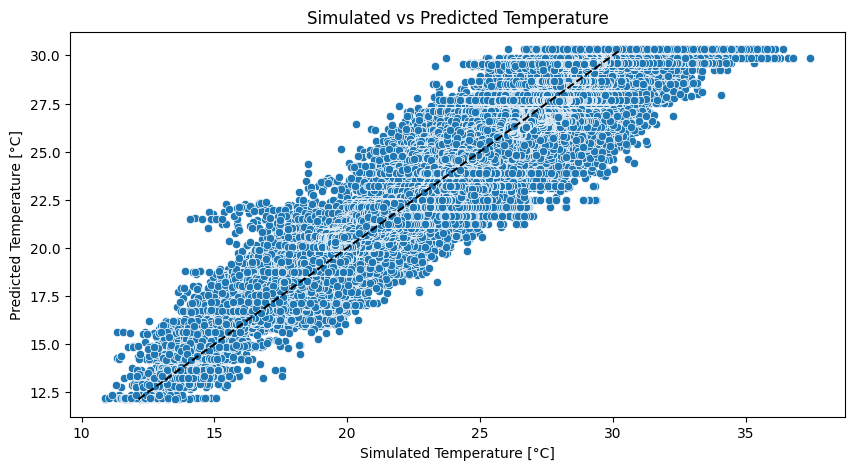

In [86]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = sns.scatterplot(x=palm_temperatures.flatten(), y=inferencedata[:, :, :, 1].flatten())
bounds = [inferencedata[:, :, :, 1].min(), inferencedata[:, :, :, 1].max()]
plt.plot(bounds, bounds, color='black', linestyle='--')
ax.set_title('Simulated vs Predicted Temperature')
ax.set_xlabel('Simulated Temperature [°C]')
ax.set_ylabel('Predicted Temperature [°C]')

### Station Evaluation

In [39]:
palmfile = nc.Dataset(palmpath, 'r')
palminfo = palm_info(palmfile)

# stations within PALM boundary (contains lat and lon indices)
stationsloc = stations_loc(palminfo)

# Temps per station (dataframe with 'stationid', 'datetime', 'PALM Temperature', 'True Temperature' and 'Predicted Temperature')
station_temps = extract_station_data(featuremaps, stationsloc, datetimes, measurementpath, inferencedata)

Boundary: N1252232.0 - E2684232.0


C:\Users\ushe\AppData\Local\Temp\ipykernel_44580\680248770.py:52: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if boundary['CH_W'] <= int(row["CH_E"]) <= boundary['CH_E'] and \
C:\Users\ushe\AppData\Local\Temp\ipykernel_44580\680248770.py:53: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  boundary['CH_S'] <= int(row["CH_N"]) <= boundary['CH_N']:
C:\Users\ushe\AppData\Local\Temp\ipykernel_44580\680248770.py:54: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  stationsloc[station] = {'lat': int(row["CH_N"]), 'lon': int(row["CH_E"]),
C:\Users\ushe\AppData\Local\Temp\ipykernel_44580\680248770.py:55: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use i

In [92]:
station_temps['True-PALM'] = station_temps['True Temperature'] - station_temps['PALM Temperature']
station_temps['True-Predicted'] = station_temps['True Temperature'] - station_temps['Predicted Temperature']
station_temps['PALM-Predicted'] = station_temps['PALM Temperature'] - station_temps['Predicted Temperature']

In [93]:
rmse = np.sqrt(np.mean(station_temps["PALM-Predicted"]**2))
print('SIMULATION - PREDICTED (stations)')
print('----------------------------------')
print(f'RMSE: {rmse:.2f}')
print(f'Mean Error: {np.mean(station_temps["Predicted-PALM"]):.2f}')
print(f'Max Error: {np.max(station_temps["Predicted-PALM"]):.2f}')
print(f'Min Error: {np.min(station_temps["Predicted-PALM"]):.2f}')
print(f'Median Error: {np.median(station_temps["Predicted-PALM"]):.2f}')
print(f'Error Std: {np.std(station_temps["Predicted-PALM"]):.2f}')

SIMULATION - PREDICTED (stations)
----------------------------------
RMSE: 0.82
Mean Error: -0.10
Max Error: 2.74
Min Error: -6.11
Median Error: -0.03
Error Std: 0.82


In [94]:
rmse = np.sqrt(np.mean(station_temps["True-PALM"]**2))
print('MEASURED - SIMULATION (stations)')
print('----------------------------------')
print(f'RMSE: {rmse:.2f}')
print(f'Mean Error: {np.mean(station_temps["True-PALM"]):.2f}')
print(f'Max Error: {np.max(station_temps["True-PALM"]):.2f}')
print(f'Min Error: {np.min(station_temps["True-PALM"]):.2f}')
print(f'Median Error: {np.median(station_temps["True-PALM"]):.2f}')
print(f'Error Std: {np.std(station_temps["True-PALM"]):.2f}')

MEASURED - SIMULATION (stations)
----------------------------------
RMSE: 3.16
Mean Error: -2.50
Max Error: 4.30
Min Error: -10.95
Median Error: -2.41
Error Std: 1.95


In [95]:
rmse = np.sqrt(np.mean(station_temps["True-Predicted"]**2))
print('MEASURED - PREDICTED (stations)')
print('----------------------------------')
print(f'RMSE: {rmse:.2f}')
print(f'Mean Error: {np.mean(station_temps["True-Predicted"]):.2f}')
print(f'Max Error: {np.max(station_temps["True-Predicted"]):.2f}')
print(f'Min Error: {np.min(station_temps["True-Predicted"]):.2f}')
print(f'Median Error: {np.median(station_temps["True-Predicted"]):.2f}')
print(f'Error Std: {np.std(station_temps["True-Predicted"]):.2f}')

MEASURED - PREDICTED (stations)
----------------------------------
RMSE: 2.97
Mean Error: -2.39
Max Error: 5.35
Min Error: -8.63
Median Error: -2.33
Error Std: 1.76


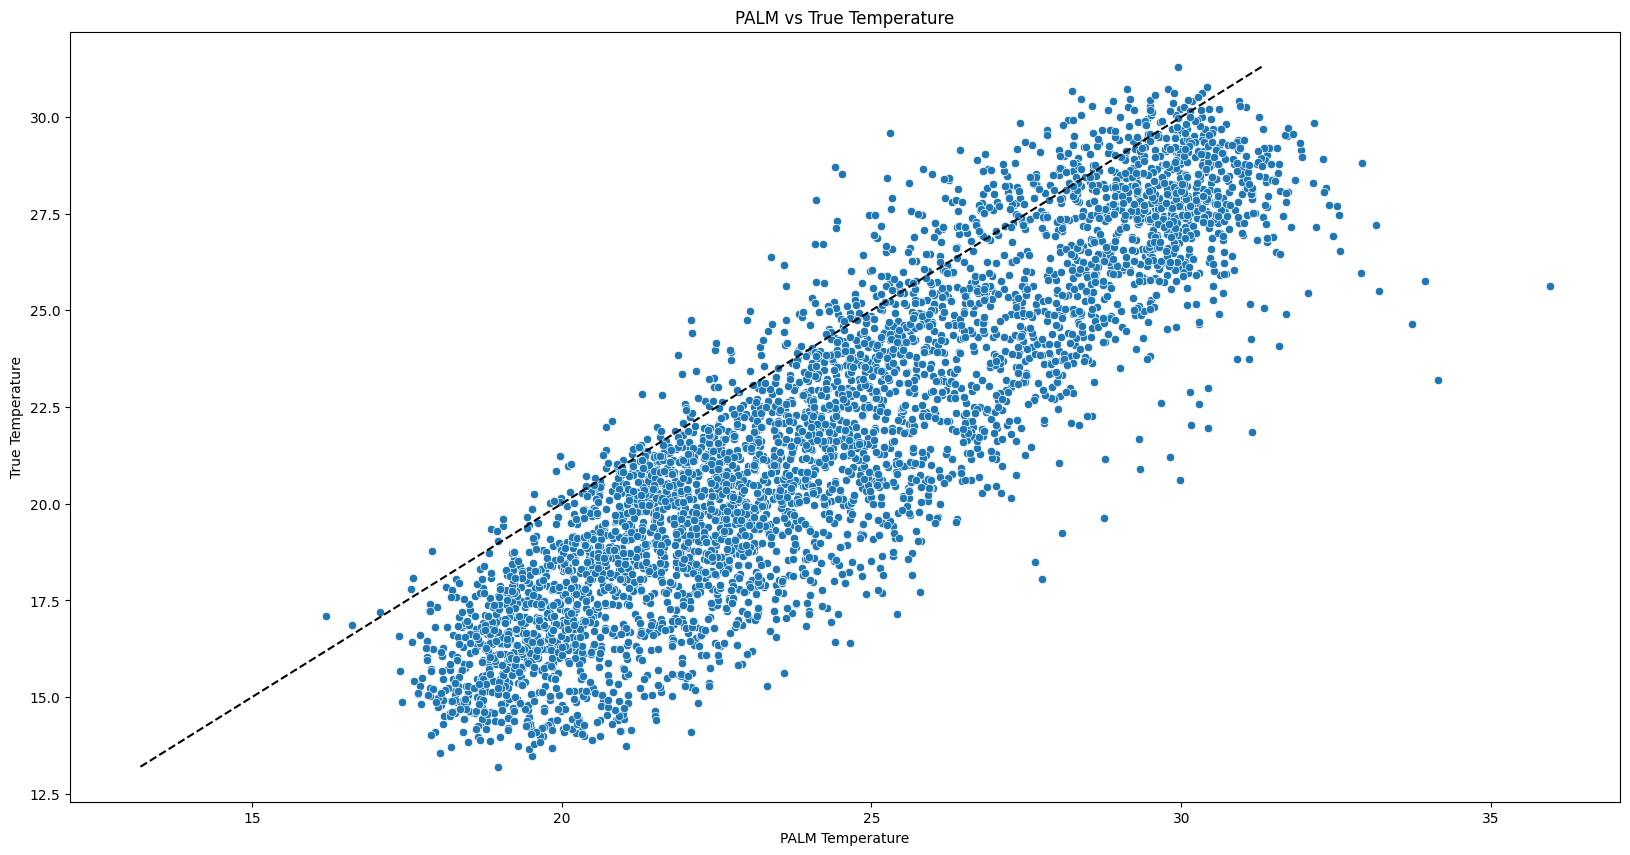

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax = sns.scatterplot(data=station_temps, x='PALM Temperature', y='True Temperature')
ax.set_title('PALM vs True Temperature')
ax.set_xlabel('PALM Temperature')
ax.set_ylabel('True Temperature')
bounds = [station_temps['True Temperature'].min(), station_temps['True Temperature'].max()]
plt.plot(bounds, bounds, color='black', linestyle='--')

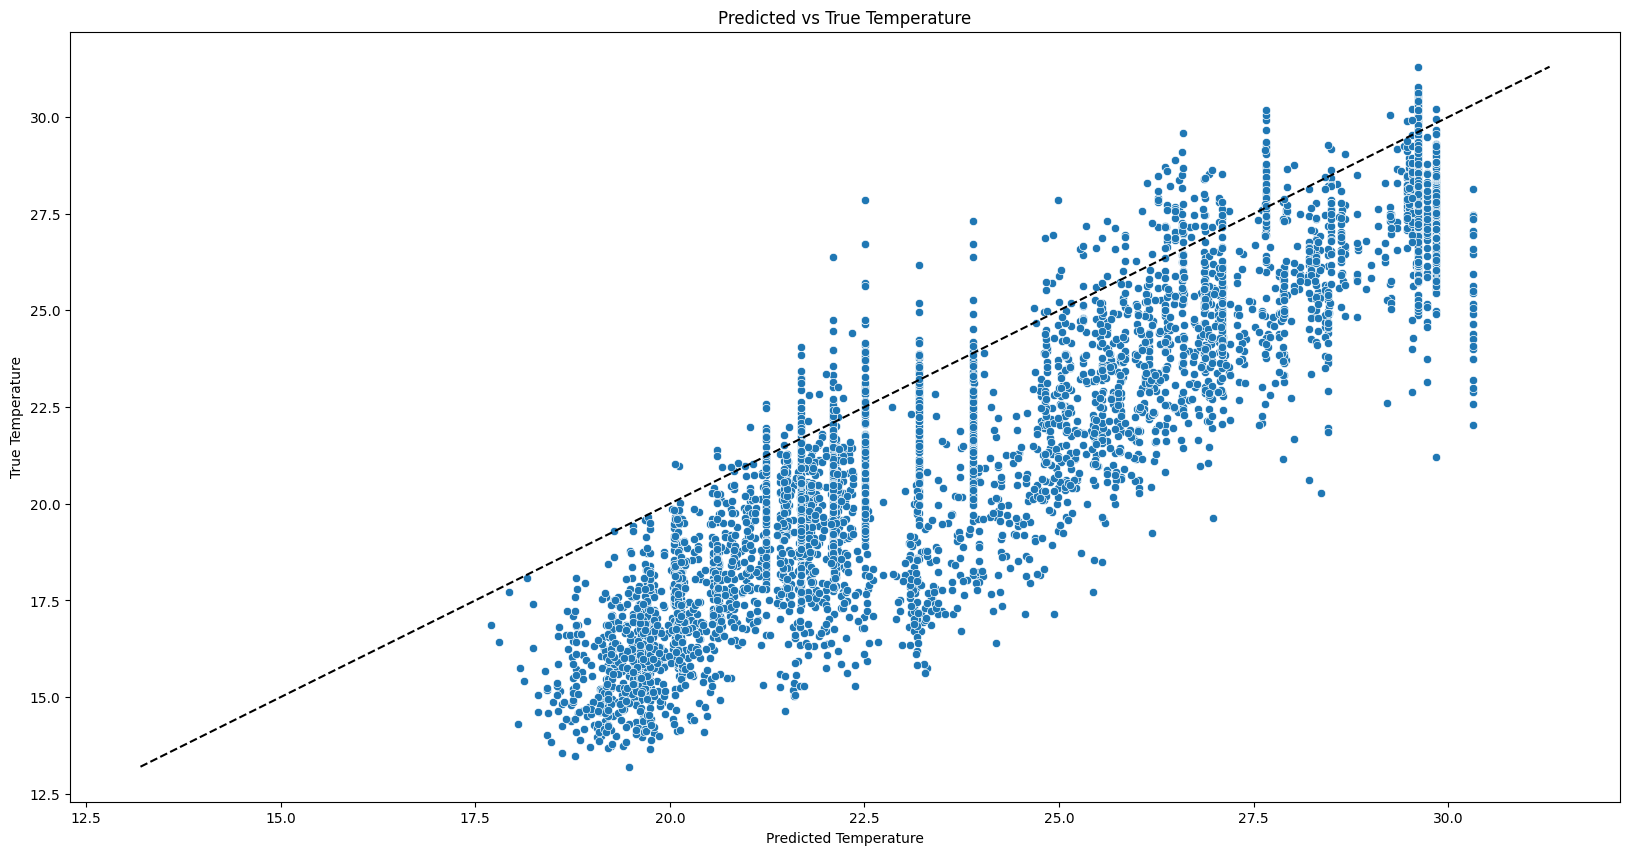

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax = sns.scatterplot(data=station_temps, x='Predicted Temperature', y='True Temperature')
ax.set_title('Predicted vs True Temperature')
ax.set_xlabel('Predicted Temperature')
ax.set_ylabel('True Temperature')
bounds = [station_temps['True Temperature'].min(), station_temps['True Temperature'].max()]
plt.plot(bounds, bounds, color='black', linestyle='--')

C:\Users\ushe\AppData\Local\Temp\ipykernel_44580\169397478.py:1: UserWarning: Ignoring `ax`; jointplot is a figure-level function.
  g = sns.jointplot(ax = ax, data=station_temps, x='datetime', y='True-PALM')


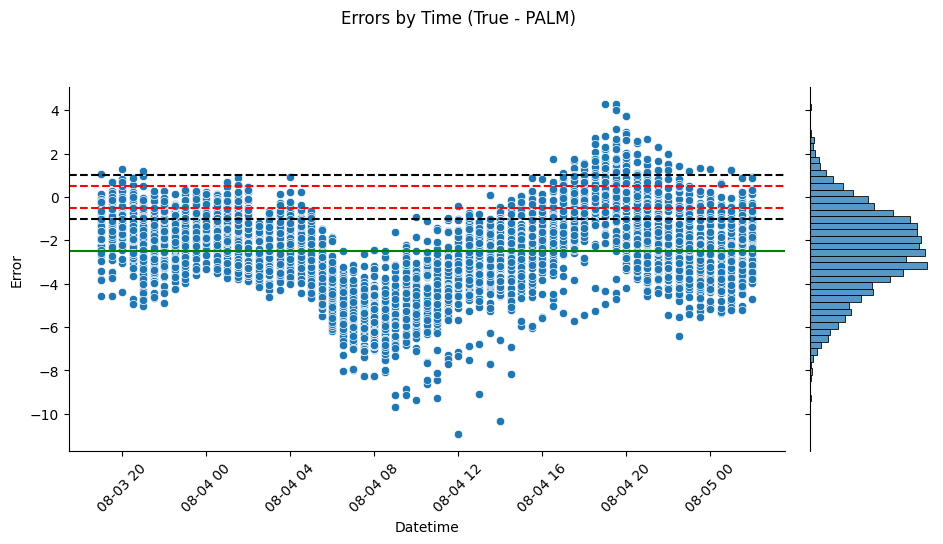

In [80]:
g = sns.jointplot(ax = ax, data=station_temps, x='datetime', y='True-PALM')
g.figure.set_figheight(5)
g.figure.set_figwidth(10)
g.ax_marg_x.remove()
plt.xticks(rotation=45)
g.set_axis_labels('Datetime', 'Error')
g.figure.suptitle('Errors by Time (True - PALM)')
# Add horizontal lines
plt.axhline(0.5, color='red', linestyle='--')
plt.axhline(-0.5, color='red', linestyle='--')
plt.axhline(1, color='black', linestyle='--')
plt.axhline(-1, color='black', linestyle='--')
plt.axhline(np.mean(station_temps['True-PALM']), color='green', linestyle='-')

C:\Users\ushe\AppData\Local\Temp\ipykernel_44580\1613950650.py:1: UserWarning: Ignoring `ax`; jointplot is a figure-level function.
  g = sns.jointplot(ax = ax, data=station_temps, x='datetime', y='True-Predicted')


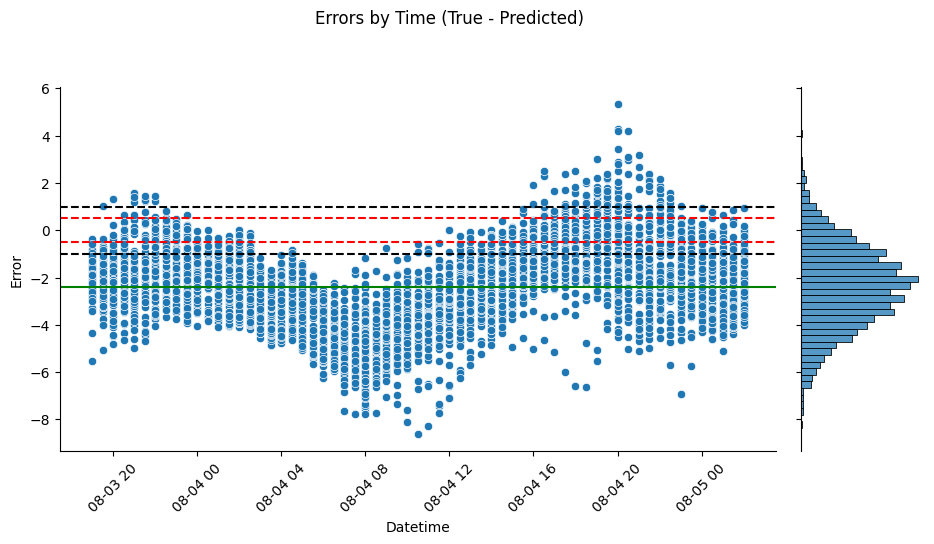

In [78]:
g = sns.jointplot(ax = ax, data=station_temps, x='datetime', y='True-Predicted')
g.figure.set_figheight(5)
g.figure.set_figwidth(10)
g.ax_marg_x.remove()
plt.xticks(rotation=45)
g.set_axis_labels('Datetime', 'Error')
g.figure.suptitle('Errors by Time (True - Predicted)')
# Add horizontal lines
plt.axhline(0.5, color='red', linestyle='--')
plt.axhline(-0.5, color='red', linestyle='--')
plt.axhline(1, color='black', linestyle='--')
plt.axhline(-1, color='black', linestyle='--')
plt.axhline(np.mean(station_temps['True-Predicted']), color='green', linestyle='-')

Text(0.5, 1.0, 'Errors by Time (True - Predicted) with Standard Deviation')

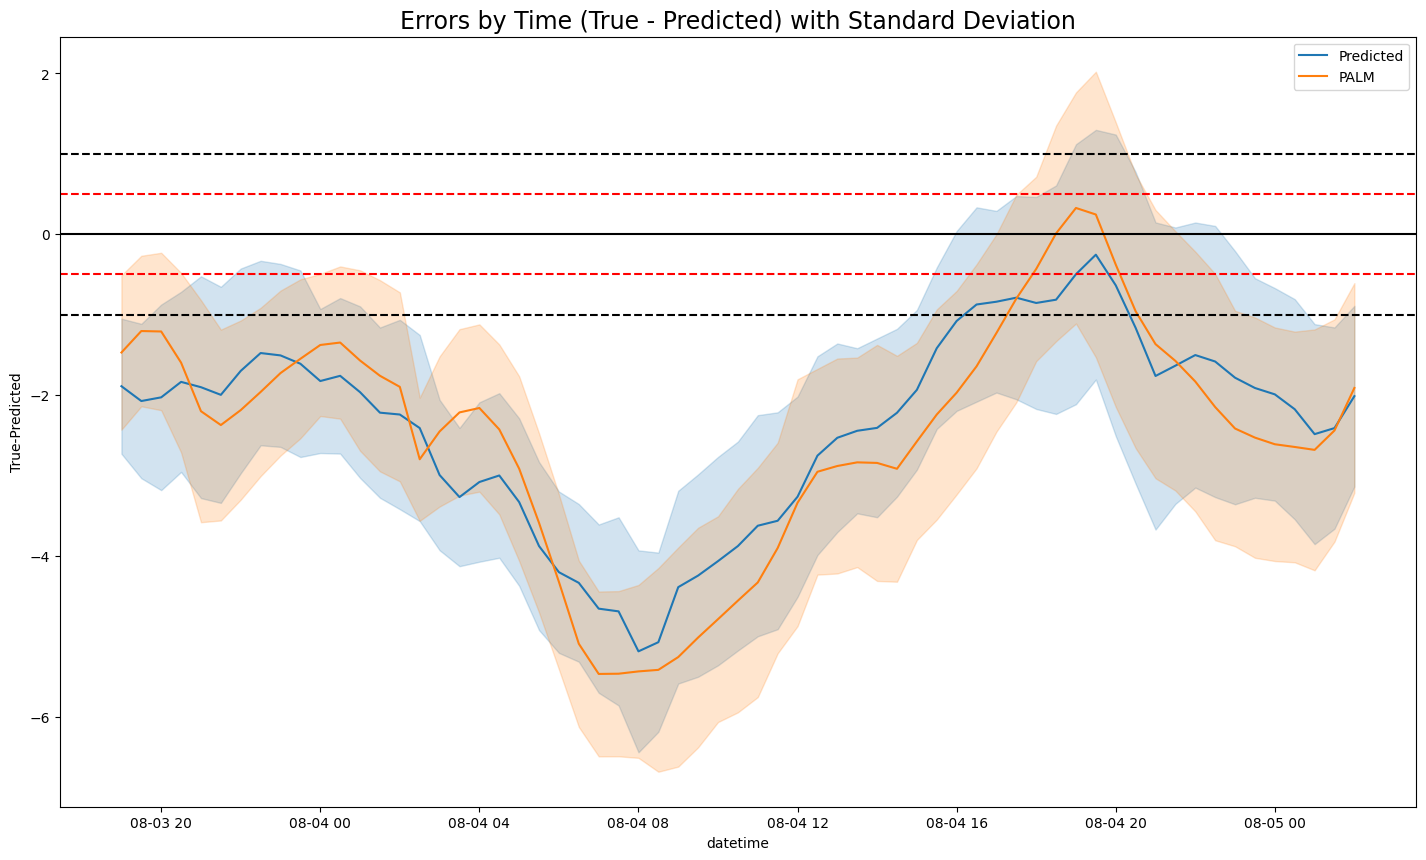

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(17.5, 10))
ax = sns.lineplot(data=station_temps, x='datetime', y='True-Predicted', label='Predicted', errorbar='sd')
ax = sns.lineplot(data=station_temps, x='datetime', y='True-PALM', label='PALM', errorbar='sd')
plt.axhline(0.5, color='red', linestyle='--')
plt.axhline(-0.5, color='red', linestyle='--')
plt.axhline(1, color='black', linestyle='--')
plt.axhline(-1, color='black', linestyle='--')
plt.axhline(0, color='black', linestyle='-')
ax.set_title('Errors by Time (True - Predicted) with Standard Deviation', fontsize=17)

(array([18111.83333333, 18112.        , 18112.16666667, 18112.33333333,
        18112.5       , 18112.66666667, 18112.83333333, 18113.        ]),
 [Text(18111.833333333332, 0, '08-03 20'),
  Text(18112.0, 0, '08-04 00'),
  Text(18112.166666666668, 0, '08-04 04'),
  Text(18112.333333333332, 0, '08-04 08'),
  Text(18112.5, 0, '08-04 12'),
  Text(18112.666666666668, 0, '08-04 16'),
  Text(18112.833333333332, 0, '08-04 20'),
  Text(18113.0, 0, '08-05 00')])

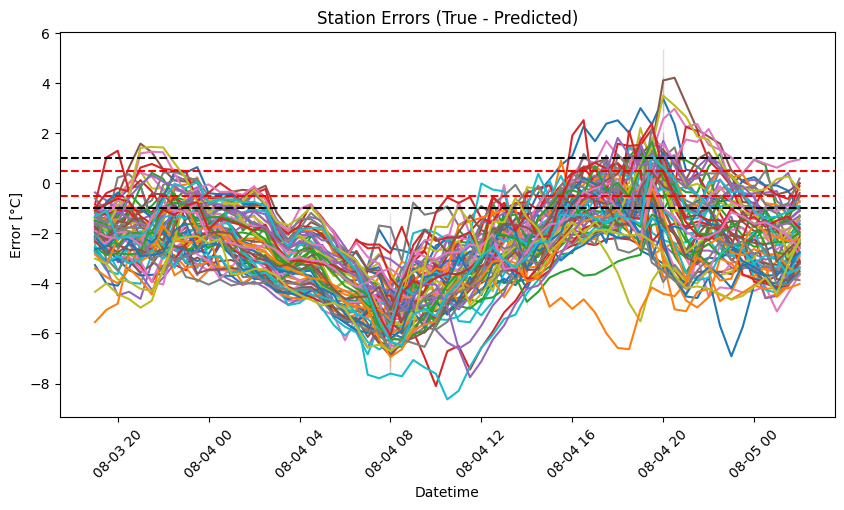

In [48]:
fig, ax = plt.subplots(figsize=(10, 5))
for station in station_temps['stationid'].unique():
    sns.lineplot(data=station_temps[station_temps['stationid'] == station], x='datetime', y='True-Predicted')
ax.set(xlabel='Datetime', ylabel='Error [°C]', title=f'Station Errors (True - Predicted)')
plt.axhline(0.5, color='red', linestyle='--')
plt.axhline(-0.5, color='red', linestyle='--')
plt.axhline(1, color='black', linestyle='--')
plt.axhline(-1, color='black', linestyle='--')
plt.xticks(rotation=45)

(array([18111.83333333, 18112.        , 18112.16666667, 18112.33333333,
        18112.5       , 18112.66666667, 18112.83333333, 18113.        ]),
 [Text(18111.833333333332, 0, '08-03 20'),
  Text(18112.0, 0, '08-04 00'),
  Text(18112.166666666668, 0, '08-04 04'),
  Text(18112.333333333332, 0, '08-04 08'),
  Text(18112.5, 0, '08-04 12'),
  Text(18112.666666666668, 0, '08-04 16'),
  Text(18112.833333333332, 0, '08-04 20'),
  Text(18113.0, 0, '08-05 00')])

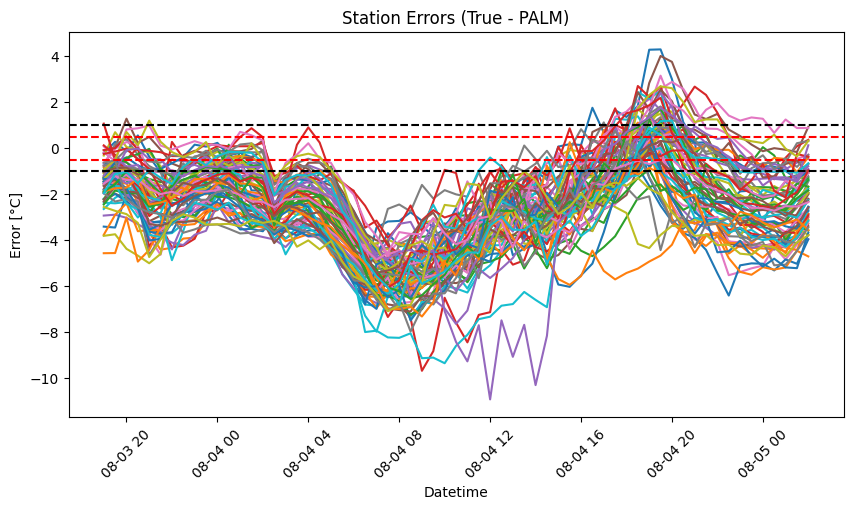

In [47]:
fig, ax = plt.subplots(figsize=(10, 5))
for station in station_temps['stationid'].unique():
    sns.lineplot(data=station_temps[station_temps['stationid'] == station], x='datetime', y='True-PALM')
ax.set(xlabel='Datetime', ylabel='Error [°C]', title=f'Station Errors (True - PALM)')
plt.axhline(0.5, color='red', linestyle='--')
plt.axhline(-0.5, color='red', linestyle='--')
plt.axhline(1, color='black', linestyle='--')
plt.axhline(-1, color='black', linestyle='--')
plt.xticks(rotation=45)

The errors are corrected according to the corresponding PALM bias at the given time. 